In [19]:
import numpy as np
import pandas as pd

In [20]:
df = pd.read_csv('./hw1_fb_dataset/Features_Variant_1.csv', header=None)

In [21]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,0,1,0
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,0
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
df.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
40944,7170111,70,497000,9,0.0,1881.0,497.2,269.0,502.318385,0.0,...,0,0,0,0,0,0,0,1,0,1
40945,7170111,70,497000,9,0.0,1881.0,497.2,269.0,502.318385,0.0,...,0,0,0,0,0,0,0,1,0,2
40946,7170111,70,497000,9,0.0,1881.0,497.2,269.0,502.318385,0.0,...,0,0,0,0,0,0,1,0,0,72
40947,7170111,70,497000,9,0.0,1881.0,497.2,269.0,502.318385,0.0,...,0,0,0,0,0,0,0,1,0,28
40948,7170111,70,497000,9,0.0,1881.0,497.2,269.0,502.318385,0.0,...,0,0,0,0,0,0,0,1,0,11


In [23]:
df.shape

(40949, 54)

In [24]:
y = df[53].values
x = df.drop(53, axis=1).values

In [25]:
for column_idx in range(x.shape[1]):
    feature = x[:, column_idx]
    std = np.std(feature)
    if std < 1e-15:
        std = 1e-15
    x[:, column_idx] = (feature - np.mean(feature)) / std

In [26]:
def h(x, w0, w):
    return w0 + np.dot(x, w)


def H(X, w0, w):
    return w0 + np.dot(X, w)


def test_h():
    assert(h([0, 1, 2], 1, [1, 2, 5]) == 13)
    
    X = [
        [1, 0, 0, 4],
        [0, 2, 0, 4],
        [0, 0, 3, 4]
    ]
    
    w = [1, 1, 1, 2]
    assert(np.all(H(X, 1, w) == [10, 11, 12]))
    
test_h()

In [27]:
def dL_dw0(X, w0, w, delta):
    return - 2 * np.sum(delta) / float(X.shape[0])

def dL_dw(X, w0, w, delta):
    return - 2 * np.ravel(np.sum((X.T * delta), axis=1)) / float(X.shape[0])

In [28]:
def MSE(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / float(y_true.shape[0])

def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

def R2(y_true, y_pred):
    return 1. - MSE(y_true, y_pred) / MSE(y_true, np.mean(y_true) * np.ones(shape=y_true.shape))

In [42]:
def grad_desc(X_train, y_train, X_test, y_test):
    w0 = 0
    w = np.random.normal(0, 0.0001, size=X_train.shape[1])
    
    n_iter = 10000
    step_size = 1e-3
    batch_size = 200
    
    lambda_ = 1e-6
    
    grad_w0 = 0
    grad_w = np.zeros(shape=w.shape)
        
    for i in range(n_iter):
        batch_indexes = np.random.choice(np.arange(X_train.shape[0]), size=batch_size, replace=False)
        X_batch = X_train[batch_indexes, :]
        y_batch = y_train[batch_indexes]

        if i % 1000 == 0:
            rmse_train = RMSE(y_train, H(X_train, w0, w))
            rmse_test = RMSE(y_test, H(X_test, w0, w))

            print('{}: RMSE(train) = {} \t RMSE(test) = {}'.format(
                i, round(rmse_train, ndigits=4), round(rmse_test, ndigits=4)
            ))
    
        y_pred = H(X_batch, w0, w)
        delta = np.transpose(y_batch - y_pred)

        w0 = w0 - step_size * dL_dw0(X_batch, w0, w, delta)
        w = w - step_size * (dL_dw(X_batch, w0, w, delta)) - lambda_ * w
    
    return w0, w

In [43]:
def CV(X, y, n_folds):
    fold_indexes = np.random.randint(0, n_folds, X.shape[0])
    
    metrics = []
    
    folds = []
    for i in range(n_folds):
        indexes = np.where(fold_indexes == i)
        x_slice = X[indexes]
        y_slice = y[indexes]
        
        indexes = np.where(fold_indexes != i)
        x_not_slice = X[indexes]
        y_not_slice = y[indexes]
        
        folds.append((x_slice, y_slice, x_not_slice, y_not_slice))
        
    for i in range(n_folds):
        x_val = folds[i][0]
        y_val = folds[i][1]
        x_learn = folds[i][2]
        y_learn = folds[i][3]
        
        w0, w = grad_desc(x_learn, y_learn, x_val, y_val)
        
        y_pred = H(x_val, w0, w)
        
        r2 = R2(y_val, y_pred)
        metrics.append(r2)
        print('fold index ' + str(i) + ': r2 = ' + str(r2))
    
    return metrics

In [44]:
CV(x, y, n_folds=5)

0: RMSE(train) = 36.2103 	 RMSE(test) = 36.3683
1000: RMSE(train) = 29.3745 	 RMSE(test) = 29.7855
2000: RMSE(train) = 29.2804 	 RMSE(test) = 29.8186
3000: RMSE(train) = 29.2404 	 RMSE(test) = 30.0184
4000: RMSE(train) = 29.2559 	 RMSE(test) = 30.1824
5000: RMSE(train) = 29.2287 	 RMSE(test) = 30.3428
6000: RMSE(train) = 29.2438 	 RMSE(test) = 30.1354
7000: RMSE(train) = 29.2074 	 RMSE(test) = 29.9075
8000: RMSE(train) = 29.2038 	 RMSE(test) = 29.8134
9000: RMSE(train) = 29.2044 	 RMSE(test) = 30.0016
fold index 0: r2 = 0.28933752232915455
0: RMSE(train) = 36.029 	 RMSE(test) = 37.0844
1000: RMSE(train) = 28.8112 	 RMSE(test) = 31.7956
2000: RMSE(train) = 28.7222 	 RMSE(test) = 31.8738
3000: RMSE(train) = 28.6764 	 RMSE(test) = 31.8725
4000: RMSE(train) = 28.635 	 RMSE(test) = 31.8133
5000: RMSE(train) = 28.6255 	 RMSE(test) = 31.7531
6000: RMSE(train) = 28.6637 	 RMSE(test) = 31.8842
7000: RMSE(train) = 28.6126 	 RMSE(test) = 31.8301
8000: RMSE(train) = 28.6065 	 RMSE(test) = 31.8233


[0.28933752232915455,
 0.2327671436007721,
 0.28488353511088016,
 0.383343288235523,
 0.2789120229922468]

In [45]:
np.mean([0.28933752232915455,
 0.2327671436007721,
 0.28488353511088016,
 0.383343288235523,
 0.2789120229922468])

0.2938487024537153

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

def draw(x, y):
    plt.figure()
    k,b = np.polyfit(x, y, 1)
    plt.scatter(x, y)
    
    x_min = np.min(x)
    x_max = np.max(x)
    y_0 = k * x_min + b
    y_1 = k * x_max + b
    plt.plot([x_min, x_max], [y_0, y_1], 'r')
    plt.show()

In [14]:
def hist(x):
    x_min = np.min(x)
    x_max = np.max(x)

    ps = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
    
    quantiles = []
    for p in ps:
        quantiles.append(np.quantile(x, p))
    
    print('xmin, xmax = {}, {}'.format(x_min, x_max))
    print(quantiles)
    plt.boxplot(x)
    plt.show()

In [15]:
def logx(x):
    if np.any(x < 0.):
        return np.log(abs(x) + 1)
        print('x less 0')
    elif np.any(x == 0):
        return np.log(x + 1)
    else:
        return np.log(x)

In [29]:
def norm_sqr(x):
    return (x - np.mean(x)) * (x - np.mean(x))

def norm_zscaling(x):
    disp = np.std(x)**2
    return (x - np.mean(x))/disp

In [17]:
ly = logx(y)

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [30]:
class ChoiceType:
    DrawXY = 0
    DrawHist = 1
    LogX = 2
    LogNormAbs = 3
    LogNormSqr = 4
    ZScaling = 5
    End = 6

    
def process_feature(x, y):
    choice = 0
    x_temp = x

    while choice != ChoiceType.End:
        print('type for drawXY={}, histX={}, log={}, logAbs={}, logSqr={}, zScal={}'.format(
            ChoiceType.DrawXY, ChoiceType.DrawHist, ChoiceType.LogX, ChoiceType.LogNormAbs, ChoiceType.LogNormSqr, ChoiceType.ZScaling))
        choice = int(input())
        
        if choice == ChoiceType.DrawXY:
            draw(x_temp, y)
        elif choice == ChoiceType.DrawHist:
            hist(x_temp)
        elif choice == ChoiceType.LogX:
            x_temp = logx(x)
            draw(x_temp, y)
        elif choice == ChoiceType.LogNormAbs:
            x_temp = logx(norm_abs(x))
            draw(x_temp, y)
        elif choice == ChoiceType.LogNormSqr:
            x_temp = logx(norm_sqr(x))
            draw(x_temp, y)
        elif choice == ChoiceType.ZScaling:
            x_temp = norm_zscaling(x)
            draw(x_temp, y)
    
    return x_temp

process feature 0
type for drawXY=0, histX=1, log=2, logAbs=3, logSqr=4, zScal=5
5


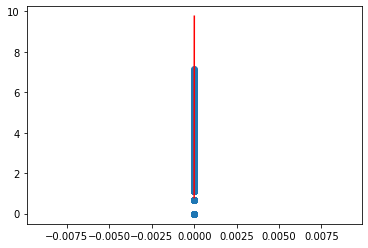

type for drawXY=0, histX=1, log=2, logAbs=3, logSqr=4, zScal=5
5


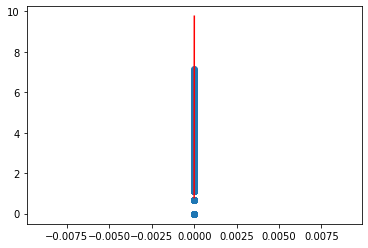

type for drawXY=0, histX=1, log=2, logAbs=3, logSqr=4, zScal=5
5


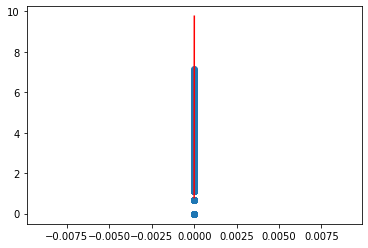

type for drawXY=0, histX=1, log=2, logAbs=3, logSqr=4, zScal=5
5


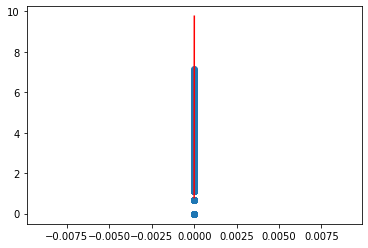

type for drawXY=0, histX=1, log=2, logAbs=3, logSqr=4, zScal=5
5


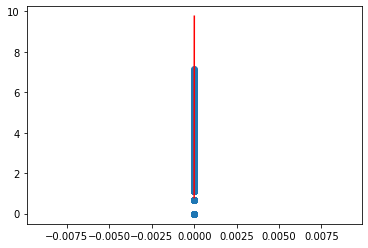

type for drawXY=0, histX=1, log=2, logAbs=3, logSqr=4, zScal=5



ValueError: invalid literal for int() with base 10: ''

In [31]:
def for_each_feature(x, y):
    for i in range(39):
        print('process feature ' + str(i))
        x[:, i] = process_feature(x[:, i], y)
    return x


for_each_feature(x.copy(), ly)

##### def for_each_feature(x, y):
    for i in range(24, 39):
        print('process feature ' + str(i))
        x[:, i] = process_feature(x[:, i], y)
    return x


for_each_feature(x.copy(), ly)

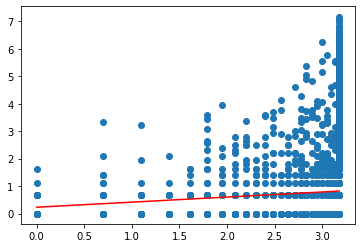

In [184]:
draw(logx(x[:,38]), ly)

In [188]:
for i in range(39):
    if i == 37:
        continue
    x[:,i] = logx(x[:,i])

In [151]:
x[:, 0] = logx(df[0])

(None, None)

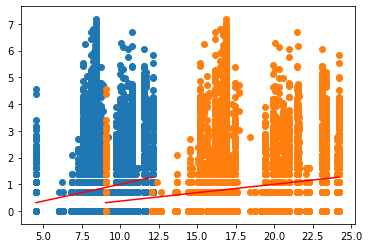

In [145]:
draw(logx(norm_abs(df[1])), ly), draw(logx(norm_sqr(df[1])), ly)

In [147]:
x[:,1] = logx(norm_sqr(df[1]))

xmin, xmax = 0.0, 12.135494589730756
[0.0, 0.0, 0.0, 0.0, 4.605170185988092, 7.952615111651, 10.233007103729488]


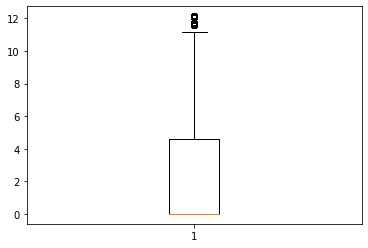

In [97]:
hist(logx(df[1]))

In [88]:
df[38].value_counts()

24    40171
1        49
2        43
19       40
3        40
17       39
9        37
23       36
22       35
6        35
11       34
20       34
10       33
15       33
16       32
12       32
21       30
4        30
14       29
5        29
18       29
13       28
8        27
7        24
Name: 38, dtype: int64

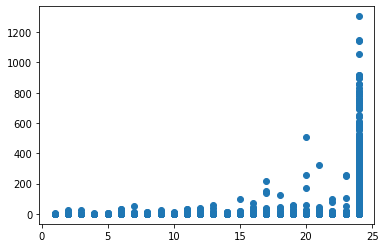

In [89]:
draw(df[38], y)

In [90]:
df[3]

0        1
1        1
2        1
3        1
4        1
        ..
40944    9
40945    9
40946    9
40947    9
40948    9
Name: 3, Length: 40949, dtype: int64

xmin, xmax = 0.0, 2341.0
[5.0, 14.0, 45.0, 241.0, 717.0, 1225.0, 1406.0]


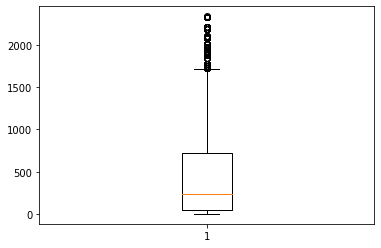

In [92]:
hist(df[5])

In [32]:
CV(x, y, 5)

0: RMSE(train) = 6598558.3114 	 RMSE(test) = 3044266.9491


/Users/mikhailsyasko/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/mikhailsyasko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/Users/mikhailsyasko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/Users/mikhailsyasko/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1000: RMSE(train) = nan 	 RMSE(test) = nan
2000: RMSE(train) = nan 	 RMSE(test) = nan
3000: RMSE(train) = nan 	 RMSE(test) = nan
4000: RMSE(train) = nan 	 RMSE(test) = nan
5000: RMSE(train) = nan 	 RMSE(test) = nan
6000: RMSE(train) = nan 	 RMSE(test) = nan
7000: RMSE(train) = nan 	 RMSE(test) = nan
8000: RMSE(train) = nan 	 RMSE(test) = nan
9000: RMSE(train) = nan 	 RMSE(test) = nan
fold index 0: r2 = nan
0: RMSE(train) = 8996805.4417 	 RMSE(test) = 7860073.2536
1000: RMSE(train) = nan 	 RMSE(test) = nan
2000: RMSE(train) = nan 	 RMSE(test) = nan
3000: RMSE(train) = nan 	 RMSE(test) = nan
4000: RMSE(train) = nan 	 RMSE(test) = nan
5000: RMSE(train) = nan 	 RMSE(test) = nan
6000: RMSE(train) = nan 	 RMSE(test) = nan
7000: RMSE(train) = nan 	 RMSE(test) = nan
8000: RMSE(train) = nan 	 RMSE(test) = nan
9000: RMSE(train) = nan 	 RMSE(test) = nan
fold index 1: r2 = nan
0: RMSE(train) = 288242.9142 	 RMSE(test) = 529986.1924
1000: RMSE(train) = nan 	 RMSE(test) = nan
2000: RMSE(train) = nan

[nan, nan, nan, nan, nan]